In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-06-11 21:52:22.911051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 21:52:23.049120: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-11 21:52:23.682615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-11 21:52:23.682679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Parameter Data

In [5]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 279
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_data_para = weight[:-1,:]
y_data_para = weight[1:,:]

for training_id in range(1, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_data_para = np.concatenate((x_data_para, weight[:-1,:]), axis = 0)
    y_data_para = np.concatenate((y_data_para, weight[1:,:]), axis = 0)

In [6]:
from sklearn.model_selection import train_test_split
x_train_para, x_test_para, y_train_para, y_test_para = train_test_split(x_data_para, y_data_para, test_size = 0.33)

In [7]:
np.shape(x_train_para)

(9192, 466)

In [8]:
from sklearn.preprocessing import StandardScaler
para_scaler = StandardScaler()
para_scaler.fit(x_train_para)
x_train_para_scaled = para_scaler.transform(x_train_para)
y_train_para_scaled = para_scaler.transform(y_train_para)
x_test_para_scaled = para_scaler.transform(x_test_para)
y_test_para_scaled = para_scaler.transform(y_test_para)

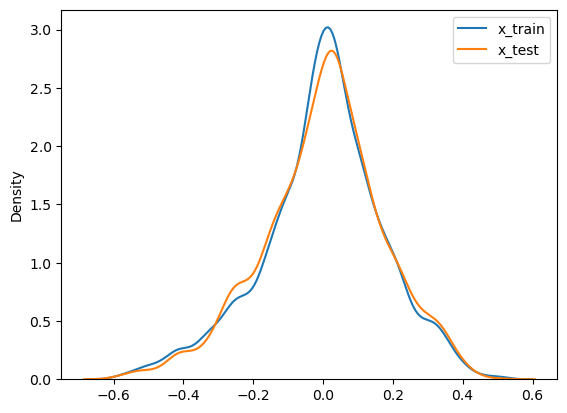

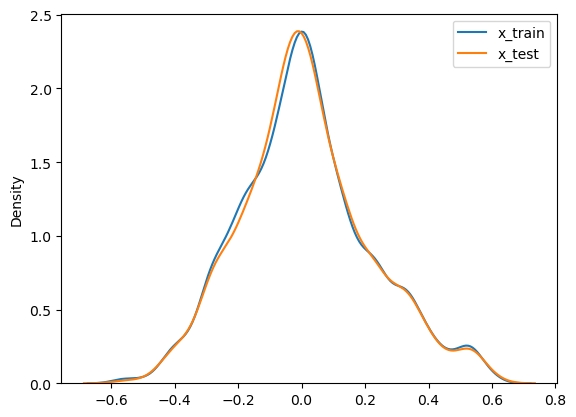

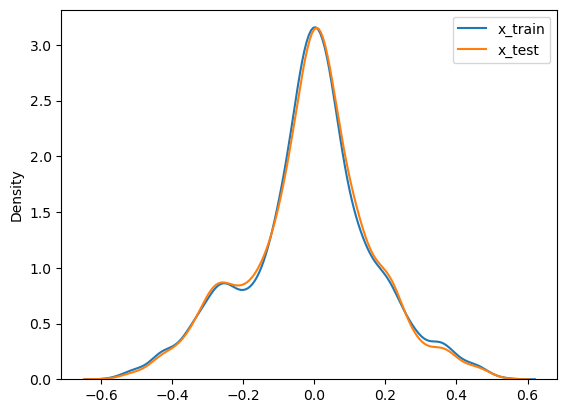

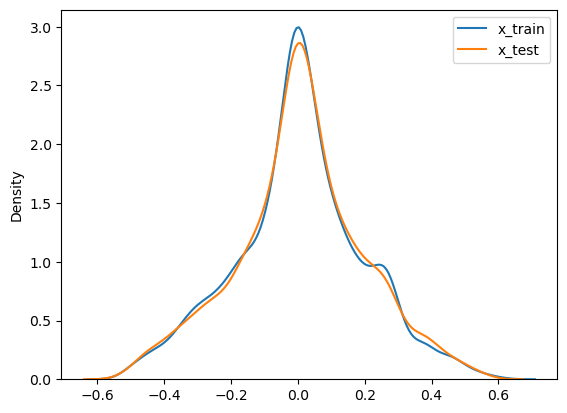

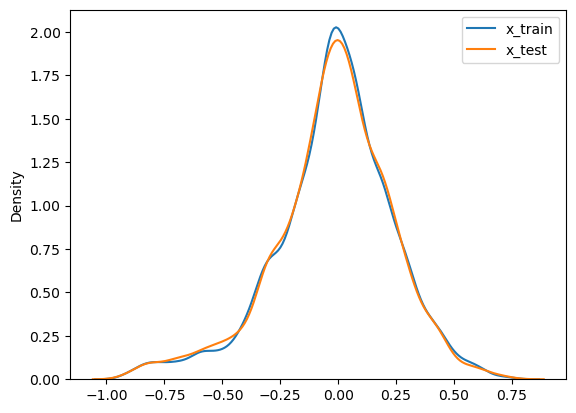

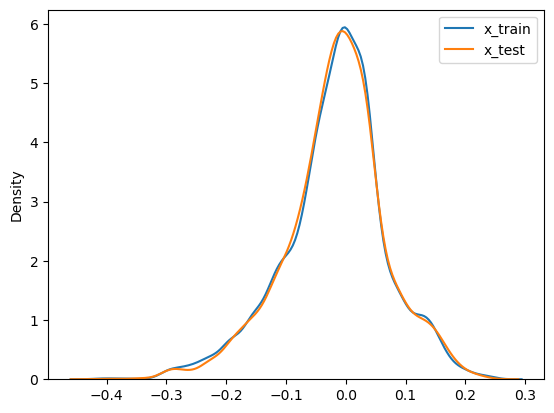

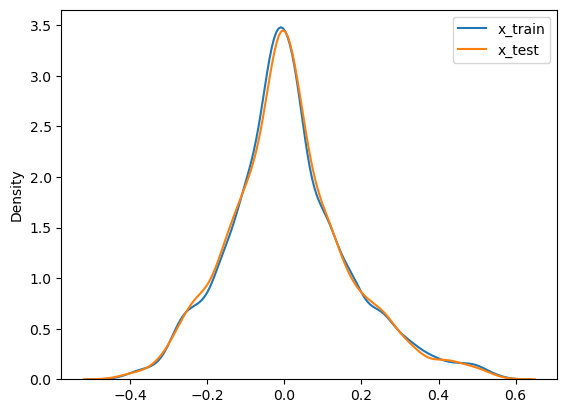

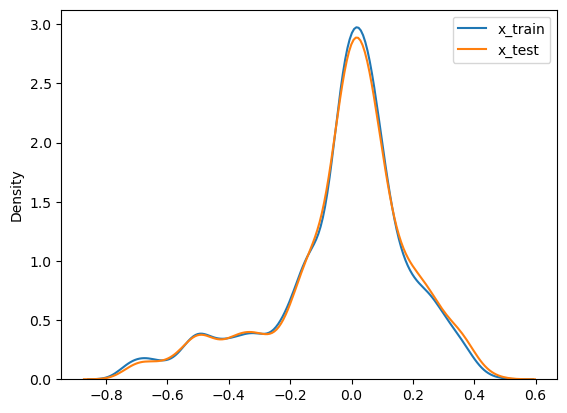

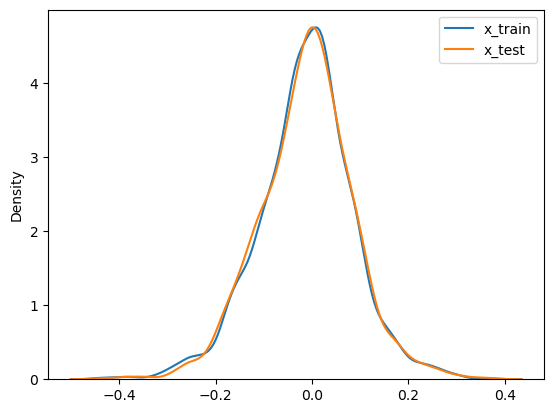

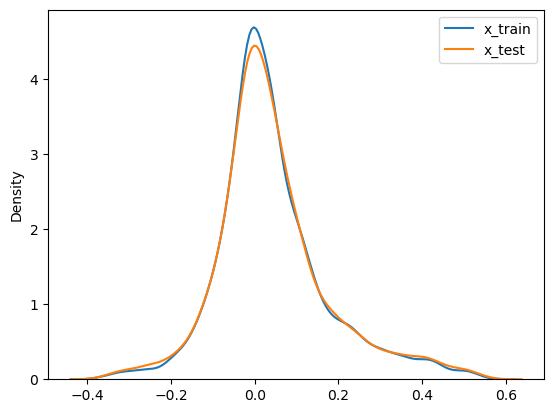

[119, 89, 309, 43, 101, 402, 209, 54, 226, 355]


In [9]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_para[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_para[:, random_number], label = 'x_test')
    plt.legend()
    plt.show()
    
print(random_numbers)

In [10]:
permuted_indices = np.random.permutation(x_train_para.shape[0])
x_train_para_scaled = x_train_para_scaled[permuted_indices, :]
y_train_para_scaled = y_train_para_scaled[permuted_indices, :]

# Mnist Data and Model

In [13]:
from sklearn.decomposition import PCA

# Load MNIST data.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train_mnist))
x_train_mnist, y_train_mnist = x_train_mnist[shuffle_index], y_train_mnist[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train_mnist = (y_train_mnist < 5)
y_test_mnist = (y_test_mnist < 5)

# Convert labels to one-hot encoding.
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist)
y_test_mnist = tf.keras.utils.to_categorical(y_test_mnist)

# Instantiate the training dataset.
x_train_mnist = np.reshape(x_train_mnist, (-1, 784))
x_test_mnist = np.reshape(x_test_mnist, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 95% of variance
x_train_reduced_mnist = pca.fit_transform(x_train_mnist.reshape(x_train_mnist.shape[0], -1))
x_test_reduced_mnist = pca.transform(x_test_mnist.reshape(x_test_mnist.shape[0], -1))

In [14]:
x_combined_reduced_mnist = np.concatenate((x_train_reduced_mnist, x_test_reduced_mnist), axis=0)
y_combined_reduced_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

In [22]:
from tensorflow import keras

inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model_mnist = keras.Model(inputs=inputs, outputs=outputs, name = 'model_mnist')

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model_mnist.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])

In [23]:
model_mnist.summary()

Model: "model_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 26)]              0         
                                                                 
 dense_2 (Dense)             (None, 16)                432       
                                                                 
 predictions (Dense)         (None, 2)                 34        
                                                                 
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


# Parameter Model

In [24]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[128,128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [27]:
dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = 466)
inputs_x = Input((np.shape(x_train_para)[1],))
model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')

In [28]:
model_psi.summary()

Model: "model_psi"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 466)]        0           []                               
                                                                                                  
 Dic_input (Dense)              (None, 128)          59648       ['input_3[0][0]']                
                                                                                                  
 Dic_hidden_0 (Dense)           (None, 128)          16512       ['Dic_input[0][0]']              
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 128)         0           ['Dic_input[0][0]',              
 mbda)                                                            'Dic_hidden_0[0][0]']   

In [29]:
inputs_x = Input((np.shape(x_train_para)[1],))
inputs_y = Input((np.shape(y_train_para)[1],))
psi_x = model_psi(inputs_x)
psi_y = model_psi(inputs_y)
k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
outputs_x = k_layer(psi_x)
outputs = outputs_x - psi_y
model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')

In [30]:
model_koopman.summary()

Model: "model_koopman"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 466)]        0           []                               
                                                                                                  
 model_psi (Functional)         (None, 466)          169298      ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 466)]        0           []                               
                                                                                                  
 k_layer (Dense)                (None, 466)          217156      ['model_psi[0][0]']  

In [31]:
inputs_x = Input((np.shape(x_train_para)[1],))
psi_x = model_psi(inputs_x)
inputs_kpsi = Input((dic.n_psi_train,))
model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x), name = 'model_auto')

In [32]:
model_auto.summary()

Model: "model_auto"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 466)]             0         
                                                                 
 model_psi (Functional)      (None, 466)               169298    
                                                                 
 model_2 (Functional)        (None, 466)               169298    
                                                                 
Total params: 338,596
Trainable params: 338,596
Non-trainable params: 0
_________________________________________________________________


In [33]:
input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
input_y = tf.keras.layers.Input(shape=(y_train_para.shape[1],))
output_auto = model_auto(input_x)
output_koopman = model_koopman([input_x, input_y])
combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman], name = 'model_combined')

In [34]:
import tensorflow.keras.backend as K

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, layer_weights, layer_biases, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.layer_weights = layer_weights
        self.layer_biases = layer_biases

    def call(self, inputs):
        # Use recovered weights and biases for computation
        outputs = K.dot(inputs, self.layer_weights)
        if self.layer_biases is not None:
            outputs = K.bias_add(outputs, self.layer_biases)
        return outputs

class para_loss(object):
    def __init__(self, lbd, model, x_data, y_data):
        self.lbd = lbd
        self.model = model
        self.x_data = x_data
        self.y_data = y_data
        self.layer_weights = []
        self.layer_biases = []

        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                self.layer_weights.append(weights[0])
                self.layer_biases.append(weights[1])
            else:
                self.layer_weights.append(None)
                self.layer_biases.append(None)

            
    def recover_parameter(self, parameter):
        parameter = tf.reshape(parameter, (-1,1))
        start_index = 0
        model_loss = 0
        for i, layer in enumerate(self.model.layers):
            weights = self.layer_weights[i]
            biases = self.layer_biases[i]
            if weights is not None:
                weights_shape = weights.shape
                weights_size = tf.size(weights)
                self.layer_weights[i] = tf.reshape(parameter[start_index:start_index + weights_size], weights_shape)
                start_index += weights_size
        
            if biases is not None:
                biases_shape = biases.shape
                biases_size = tf.size(biases)
                self.layer_biases[i] = tf.reshape(parameter[start_index:start_index + biases_size], biases_shape)
                start_index += biases_size
            
            if isinstance(layer, CustomLayer):
                layer.set_weights([self.layer_weights[i], self.layer_biases[i]])            
        model_loss += tf.reduce_mean(tf.keras.losses.MSE(self.model(self.x_data), self.y_data))
        return model_loss
           
    def loss_fun(self, y_true, y_pred):
        koopman_loss = tf.keras.losses.MSE(y_pred[1], y_true[1])
        loss_true = self.recover_parameter(y_true)
        loss_pred = self.recover_parameter(y_pred) 
        loss_pred = tf.expand_dims(loss_pred, axis=0)
        loss_true = tf.expand_dims(loss_true, axis=0)
        reconstruct_loss = tf.keras.losses.MSE(loss_pred, loss_true)
        print(reconstruct_loss)
        return self.lbd * koopman_loss + (1 - self.lbd) * reconstruct_loss

In [35]:
batch_size = 256
epochs = 1000
lbd = 0.1

In [36]:
loss = para_loss(lbd, model_mnist, x_combined_reduced_mnist, y_combined_reduced_mnist)

In [37]:
combined_model.compile(optimizer='adam', loss=loss.loss_fun)

In [38]:
# combined_model.compile(optimizer='adam', loss='mse')

In [42]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# 创建一个TensorBoard回调函数，设置日志目录
log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir)

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_layer):
        super(CustomCallback, self).__init__()
        self.k_layer = k_layer

    def on_train_batch_end(self, batch, logs=None):
        layer_params = self.model.get_layer('model_koopman').get_layer(self.k_layer).get_weights()
        grads = self.model.optimizer.get_gradients(self.model.total_loss, self.model.trainable_weights)
        psi_outputs = self.model.get_layer('model_koopman').get_layer('model_psi').predict(x_train_para)
        with tf.summary.create_file_writer(log_dir).as_default():
            tf.summary.histogram("model_psi_output", psi_outputs, step=self.model.optimizer.iterations)

# 创建自定义回调函数并添加到训练过程中
custom_callback = CustomCallback(k_layer='k_layer')  # 替换为model_koopman中要记录的层的名称
callbacks = [tensorboard_callback, custom_callback]

history = combined_model.fit(
    [x_train_para, y_train_para],
    [x_train_para, tf.zeros_like(model_psi(x_train_para))],
    validation_data=([x_test_para, y_test_para], [x_test_para, tf.zeros_like(model_psi(x_test_para))]),
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)


Epoch 1/1000


AttributeError: 'Adam' object has no attribute 'get_gradients'

In [297]:
history = combined_model.fit([x_train_para, y_train_para], 
                             [x_train_para, tf.zeros_like(model_psi(x_train_para))], 
                             validation_data=([x_test_para, y_test_para], 
                                              [x_test_para, tf.zeros_like(model_psi(x_test_para))]),
                             verbose=1,
                             epochs=epochs, batch_size=batch_size,
                             callbacks=[tensorboard_callback])


Epoch 1/1000
Tensor("loss_fun/Mean_5:0", shape=(), dtype=float32)
Tensor("loss_fun_1/Mean_5:0", shape=(), dtype=float32)
Tensor("loss_fun/Mean_5:0", shape=(), dtype=float32)
Tensor("loss_fun_1/Mean_5:0", shape=(), dtype=float32)
36/36 [==============================] - ETA: 0s - loss: 0.0608 - model_31_loss: 0.0355 - model_29_loss: 0.0253Tensor("loss_fun/Mean_5:0", shape=(), dtype=float32)
Tensor("loss_fun_1/Mean_5:0", shape=(), dtype=float32)
36/36 [==============================] - 3s 32ms/step - loss: 0.0608 - model_31_loss: 0.0355 - model_29_loss: 0.0253 - val_loss: 0.0467 - val_model_31_loss: 0.0291 - val_model_29_loss: 0.0176
Epoch 2/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.0355 - model_31_loss: 0.0219 - model_29_loss: 0.0136 - val_loss: 0.0251 - val_model_31_loss: 0.0162 - val_model_29_loss: 0.0089
Epoch 3/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.0224 - model_31_loss: 0.0142 - model_29_loss: 0.0082 - val_loss: 0.0155 - val_

Epoch 38/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0031 - model_31_loss: 0.0029 - model_29_loss: 1.6738e-04 - val_loss: 0.0028 - val_model_31_loss: 0.0027 - val_model_29_loss: 1.4371e-04
Epoch 39/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0029 - model_31_loss: 0.0027 - model_29_loss: 1.5927e-04 - val_loss: 0.0029 - val_model_31_loss: 0.0028 - val_model_29_loss: 1.4848e-04
Epoch 40/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0028 - model_31_loss: 0.0027 - model_29_loss: 1.4143e-04 - val_loss: 0.0029 - val_model_31_loss: 0.0028 - val_model_29_loss: 1.4532e-04
Epoch 41/1000
36/36 [==============================] - 0s 14ms/step - loss: 0.0027 - model_31_loss: 0.0026 - model_29_loss: 1.3942e-04 - val_loss: 0.0030 - val_model_31_loss: 0.0028 - val_model_29_loss: 1.4550e-04
Epoch 42/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0032 - model_31_loss: 0.0030 - model_29_loss: 1.5915e-04 - val_los

36/36 [==============================] - 1s 15ms/step - loss: 0.0037 - model_31_loss: 0.0036 - model_29_loss: 1.2150e-04 - val_loss: 0.0038 - val_model_31_loss: 0.0036 - val_model_29_loss: 1.2916e-04
Epoch 115/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0040 - model_31_loss: 0.0039 - model_29_loss: 1.2194e-04 - val_loss: 0.0035 - val_model_31_loss: 0.0034 - val_model_29_loss: 1.2275e-04
Epoch 116/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0038 - model_31_loss: 0.0036 - model_29_loss: 1.3811e-04 - val_loss: 0.0035 - val_model_31_loss: 0.0033 - val_model_29_loss: 1.3127e-04
Epoch 117/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0039 - model_31_loss: 0.0037 - model_29_loss: 1.4259e-04 - val_loss: 0.0037 - val_model_31_loss: 0.0036 - val_model_29_loss: 1.2991e-04
Epoch 118/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0034 - model_31_loss: 0.0033 - model_29_loss: 1.2390e-04 - val_loss: 0.0037 

36/36 [==============================] - 1s 14ms/step - loss: 0.0039 - model_31_loss: 0.0037 - model_29_loss: 1.3954e-04 - val_loss: 0.0034 - val_model_31_loss: 0.0033 - val_model_29_loss: 1.3159e-04
Epoch 191/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0044 - model_31_loss: 0.0042 - model_29_loss: 1.5559e-04 - val_loss: 0.0041 - val_model_31_loss: 0.0039 - val_model_29_loss: 1.6205e-04
Epoch 192/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0040 - model_31_loss: 0.0038 - model_29_loss: 1.5557e-04 - val_loss: 0.0039 - val_model_31_loss: 0.0038 - val_model_29_loss: 1.6464e-04
Epoch 193/1000
36/36 [==============================] - 1s 14ms/step - loss: 0.0043 - model_31_loss: 0.0041 - model_29_loss: 1.8804e-04 - val_loss: 0.0039 - val_model_31_loss: 0.0037 - val_model_29_loss: 1.8136e-04
Epoch 194/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0038 - model_31_loss: 0.0036 - model_29_loss: 1.6880e-04 - val_loss: 0.0037 

KeyboardInterrupt: 

In [ ]:
key = list(history.history.keys())

In [ ]:
key

In [ ]:
plt.plot(history.history[key[0]])
plt.plot(history.history[key[3]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(history.history[key[1]])
plt.plot(history.history[key[4]])
plt.title('autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(history.history[key[2]])
plt.plot(history.history[key[5]])
plt.title('Koopman loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()